<a href="https://colab.research.google.com/github/sagardeshmukh81/Littlebits/blob/master/DEMO_Sam_2_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning SAM 2

Fine Tuning on google colab


---

### 📚 Tutorial

Check out the [tutorial on YouTube](https://youtu.be/bcwLbmALyLI) for a detailed walkthrough.

---

### 💡 Inspiration

This code was inspired by a brilliant tutorial by [Sagieppel on Medium](https://medium.com/@sagieppel/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3).

---

# Installation

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 510 (delta 134), reused 74 (delta 50), pack-reused 310 (from 1)
Receiving objects: 100% (510/510), 78.53 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [ ]:
%cd /content/segment-anything-2

/content/segment-anything-2


In [ ]:
!pip install -e .

In [ ]:
!ls

sample_data  segment-anything-2


In [ ]:
!pip install opencv-python

!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt

--2024-08-15 14:56:52--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_small.pt’

sam2_hiera_small.pt 100%[===================>] 175.77M   245MB/s    in 0.7s    

2024-08-15 14:56:53 (245 MB/s) - ‘sam2_hiera_small.pt’ saved [184309650/184309650]



## Download Image

In [ ]:
!wget https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1

--2024-08-15 14:57:26--  https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2960213543 (2.8G) [application/octet-stream]
Saving to: ‘LabPicsV1.zip?download=1’

LabPicsV1.zip?downl 100%[===================>]   2.76G  28.4MB/s    in 1m 41s  

2024-08-15 14:59:08 (27.9 MB/s) - ‘LabPicsV1.zip?download=1’ saved [2960213543/2960213543]



In [ ]:
!unzip LabPicsV1.zip?download=1

Streaming output truncated to the last 5000 lines.
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223510.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223603.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223609.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223616.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223623.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_184823.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_184825.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_204704.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181225_231505.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181225_231509.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181226_184458.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG

# Preparing Data

In [ ]:
import numpy as np
import torch
import cv2
from google.colab.patches import cv2_imshow
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



# Training Preparation

In [ ]:
data_dir=r"/content/LabPicsV1/" # Path to LabPics1 dataset folder
data=[] # list of files in dataset

for ff, name in enumerate(os.listdir(data_dir+"Simple/Train/Image/")):  # go over all folder annotation
    data.append({"image":data_dir+"Simple/Train/Image/"+name,"annotation":data_dir+"Simple/Train/Instance/"+name[:-4]+".png"})


In [ ]:
data[7]

{'image': '/content/LabPicsV1/Simple/Train/Image/IMG_20181213_183405.jpg',
 'annotation': '/content/LabPicsV1/Simple/Train/Instance/IMG_20181213_183405.png'}

In [ ]:
def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)
   #  select image

        ent  = data[np.random.randint(len(data))] # choose random entry
        Img = cv2.imread(ent["image"])[...,::-1]  # read image
        ann_map = cv2.imread(ent["annotation"]) # read annotation
   # resize image

        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
        Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
   # merge vessels and materials annotations

        mat_map = ann_map[:,:,0] # material annotation map
        ves_map = ann_map[:,:,2] # vessel  annotaion map
        mat_map[mat_map==0] = ves_map[mat_map==0]*(mat_map.max()+1) # merged map


        inds = np.unique(mat_map)[1:] # load all indices
        points= []
        masks = []
        for ind in inds:
            mask=(mat_map == ind).astype(np.uint8) # make binary mask
            masks.append(mask)
            coords = np.argwhere(mask > 0) # get all coordinates in mask
            yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
            points.append([[yx[1], yx[0]]])
        return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

In [ ]:
sam2_checkpoint = "sam2_hiera_small.pt" # path to model weight
model_cfg = "sam2_hiera_s.yaml" # model config

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model) # load net

In [ ]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder


PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [ ]:
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() # set mixed precision

In [ ]:

# Training loop

for itr in range(1000):
    with torch.cuda.amp.autocast(): # cast to mix precision

            image,mask,input_point, input_label = read_batch(data) # load data batch
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encodet to the image

            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder

            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

            # Score loss calculation (intersection over union) IOU

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch") # save model

            # Display results

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            print("step)",itr, "Accuracy(IOU)=",mean_iou)

step) 0 Accuracy(IOU)= 0.003413473963737488
step) 1 Accuracy(IOU)= 0.007119375413656235
step) 2 Accuracy(IOU)= 0.014609054691135884
step) 3 Accuracy(IOU)= 0.019486454930776956
step) 4 Accuracy(IOU)= 0.025288387466277536
step) 5 Accuracy(IOU)= 0.03203235813530068
step) 6 Accuracy(IOU)= 0.036304028541507945
step) 7 Accuracy(IOU)= 0.04060873587286075
step) 8 Accuracy(IOU)= 0.042704187208037016
step) 9 Accuracy(IOU)= 0.04442270214347465
step) 10 Accuracy(IOU)= 0.05187235215145885
step) 11 Accuracy(IOU)= 0.05804797470023387
step) 12 Accuracy(IOU)= 0.05997373168523761
step) 13 Accuracy(IOU)= 0.06427939583666221
step) 14 Accuracy(IOU)= 0.06637240768779343
step) 15 Accuracy(IOU)= 0.06656830291545326
step) 16 Accuracy(IOU)= 0.07147439949502522
step) 17 Accuracy(IOU)= 0.07623878445686971
step) 18 Accuracy(IOU)= 0.0802701675216104
step) 19 Accuracy(IOU)= 0.0880292343781936
step) 20 Accuracy(IOU)= 0.09111702559487843
step) 21 Accuracy(IOU)= 0.09538804945266104
step) 22 Accuracy(IOU)= 0.10043175461

#Inference: Loading and using the trained model

In [ ]:
!wget https://raw.githubusercontent.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code/main/sample_image.jpg
!wget https://raw.githubusercontent.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code/main/sample_mask.png

--2024-08-15 15:08:29--  https://raw.githubusercontent.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code/main/sample_image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147160 (144K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 143.71K  --.-KB/s    in 0.03s   

2024-08-15 15:08:29 (4.35 MB/s) - ‘sample_image.jpg’ saved [147160/147160]

--2024-08-15 15:08:29--  https://raw.githubusercontent.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code/main/sample_mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

In [ ]:
# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()


# Load image

image_path = r"sample_image.jpg" # path to image
mask_path = r"sample_mask.png" # path to mask, the mask will define the image region to segment
num_samples = 30 # number of points/segment to sample


In [ ]:
def read_image(image_path, mask_path): # read and resize image and mask
        img = cv2.imread(image_path)[...,::-1]  # read image
        mask = cv2.imread(mask_path,0)
        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img, mask


def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)


In [ ]:
# read image and sample points
image,mask = read_image(image_path, mask_path)
input_points = get_points(mask,num_samples)

In [ ]:
# Load model you need to have pretrained model already made
sam2_checkpoint = "sam2_hiera_small.pt" # "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_s.yaml" # "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")


In [ ]:
# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("model.torch"))


<All keys matched successfully>

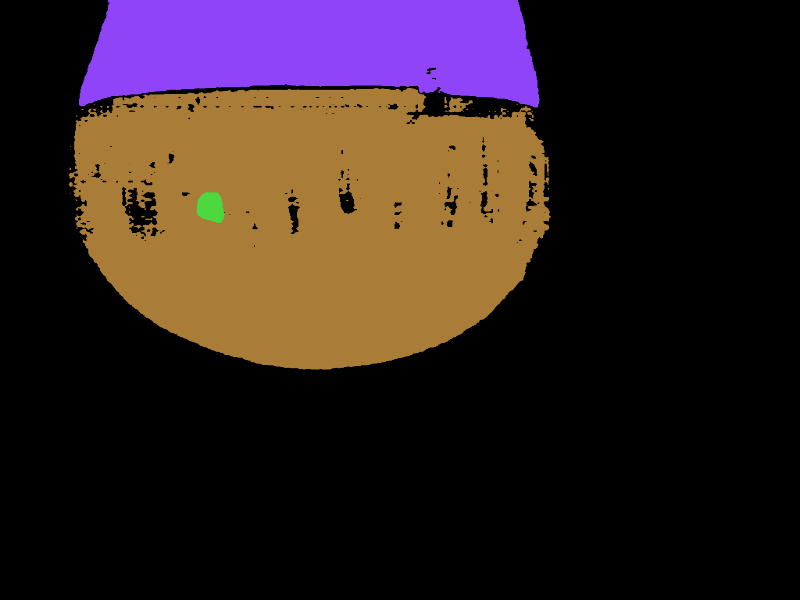

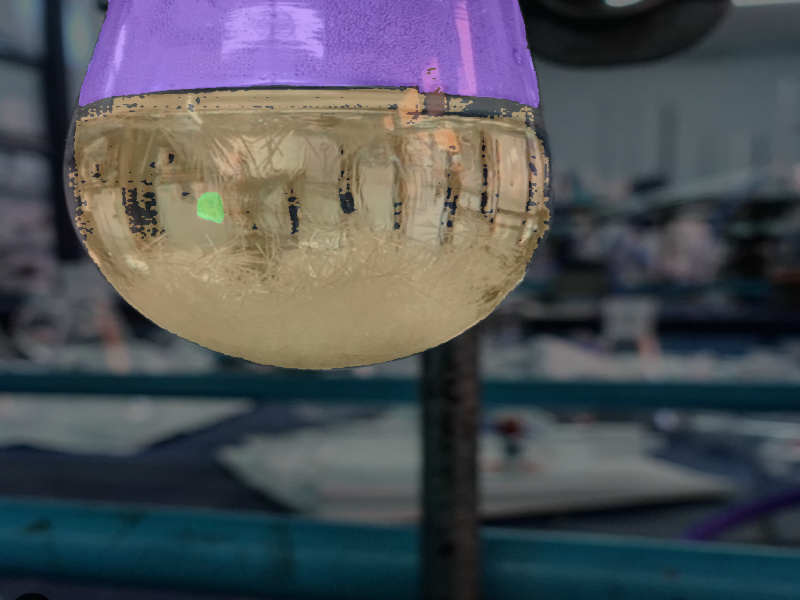

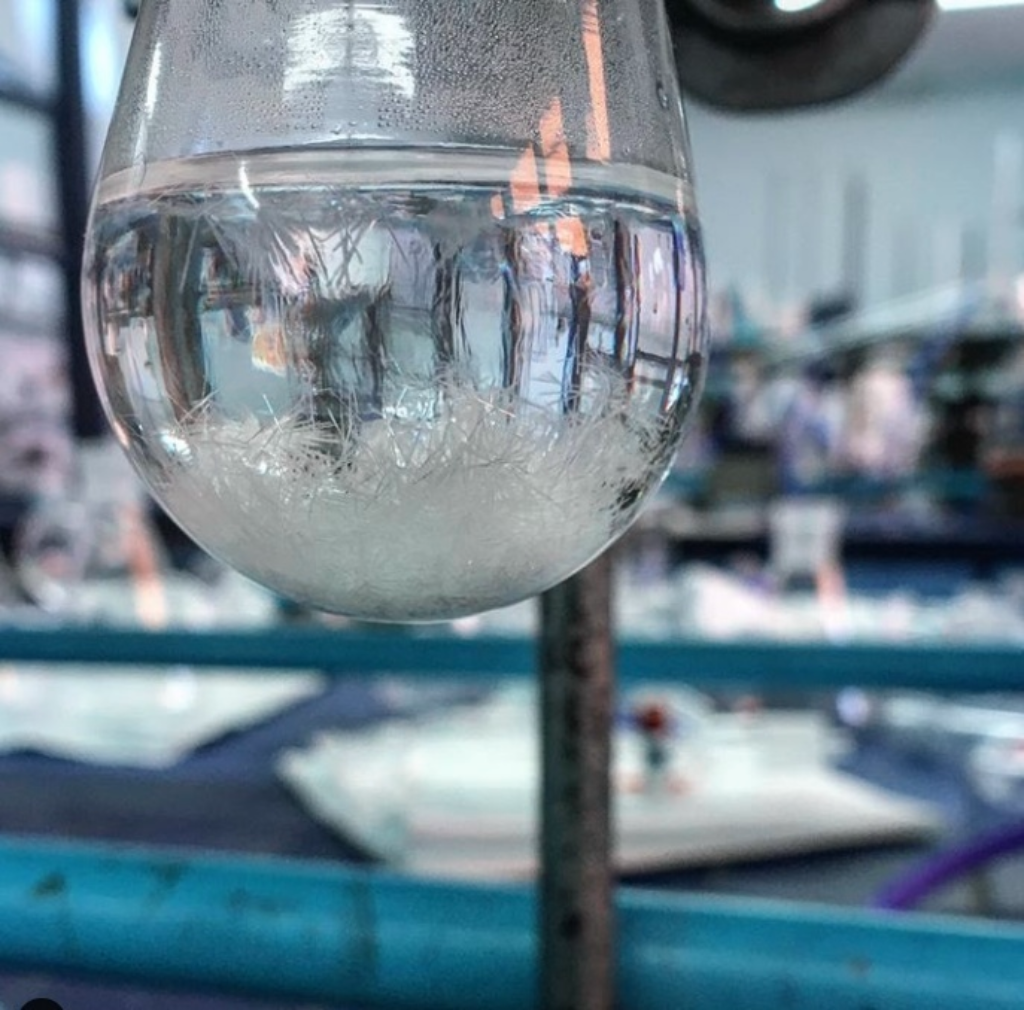

-1

In [ ]:
# predict mask

with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0],1])
        )

# Short predicted masks from high to low score

np_masks = np.array(masks[:,0]) # remove .cpu().numpy() as masks is already a numpy array
np_scores = scores[:,0]
shorted_masks = np_masks[np.argsort(np_scores)][::-1]


# Stitch predicted mask into one segmentation mask

seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
for i in range(shorted_masks.shape[0]):
    mask = shorted_masks[i]
    if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
    mask[occupancy_mask]=0
    # Convert mask to boolean for indexing
    seg_map[mask > 0.5] = i + 1  # Assuming 0.5 as the threshold for positive prediction
    occupancy_mask[mask > 0.5] = 1


# create colored annotation map
height, width = seg_map.shape

# Create an empty RGB image for the colored annotation
rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
# Map each class number to a random  color


for id_class in range(1,seg_map.max()+1):
    rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

# save and display

cv2.imwrite("annotation.png",rgb_image)
cv2.imwrite("mix.png",(rgb_image/2+image/2).astype(np.uint8))

cv2_imshow(cv2.resize(rgb_image, (800, 600))) # Use cv2_imshow instead of cv2.imshow
cv2_imshow(cv2.resize((rgb_image/2+image/2).astype(np.uint8),(800, 600))) # Use cv2_imshow instead of cv2.imshow
cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow

cv2.waitKey()